In [ ]:
# Generate demo CSV if not exists
import os
import pandas as pd

csv_path = 'data/instructor_dirty.csv'
os.makedirs('data', exist_ok=True)

#creating the data set if there are not exist in my folder
if not os.path.exists(csv_path):
    df_demo = pd.DataFrame({
        'numeric_col': [10, None, 40, 55, 70],
        'category_col': ['A', 'B', 'A', 'B', 'C'],
        'price': ['$100', '$200', '$150', None, '$250'],
        'date_str': ['2025-08-01','2025-08-02',None,'2025-08-04','2025-08-05'],
        'category': ['Electronics','Furniture','Toys','Clothing',None]
    })
    df_demo.to_csv(csv_path, index=False)
    print(f"Demo CSV created at {csv_path}")
else:
    print(f"CSV already exists at {csv_path}")

CSV already exists at data/instructor_dirty.csv


# Stage 6: Comprehensive Data Preprocessing
- Missing data handling (MCAR/MAR/MNAR, visualization, fill/drop strategies)
- Filtering and threshold-based row drops
- Type corrections (currency, dates, categorical)
- Scaling/normalization (MinMax, StandardScaler)
- Reusable functions for reproducibility and workflow


In [ ]:
# Imports
import pandas as pd
import numpy as np

#visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing and Scaling for data clean up
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import missingno as msno

## Load Dataset

In [ ]:
# Load instructor CSV
df = pd.read_csv('data/instructor_dirty.csv')
df.head()

,numeric_col,category_col,price,date_str,category
0,10.0,A,$100,2025-08-01,Electronics
1,NaN,B,$200,2025-08-02,Furniture
2,40.0,A,$150,NaN,Toys
3,55.0,B,NaN,2025-08-04,Clothing
4,70.0,C,$250,2025-08-05,NaN


## Inspect Missingness

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   numeric_col   4 non-null      float64
 1   category_col  5 non-null      object 
 2   price         4 non-null      object 
 3   date_str      4 non-null      object 
 4   category      4 non-null      object 
dtypes: float64(1), object(4)
memory usage: 332.0+ bytes


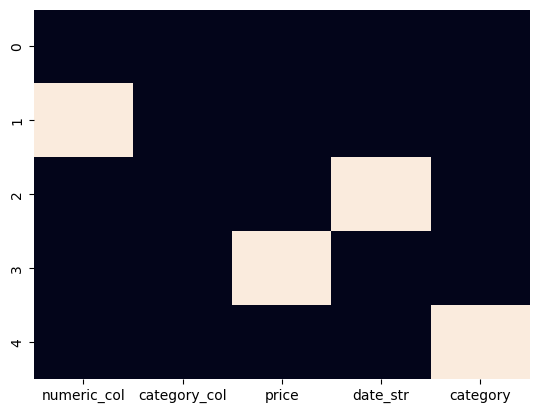

<Axes: >

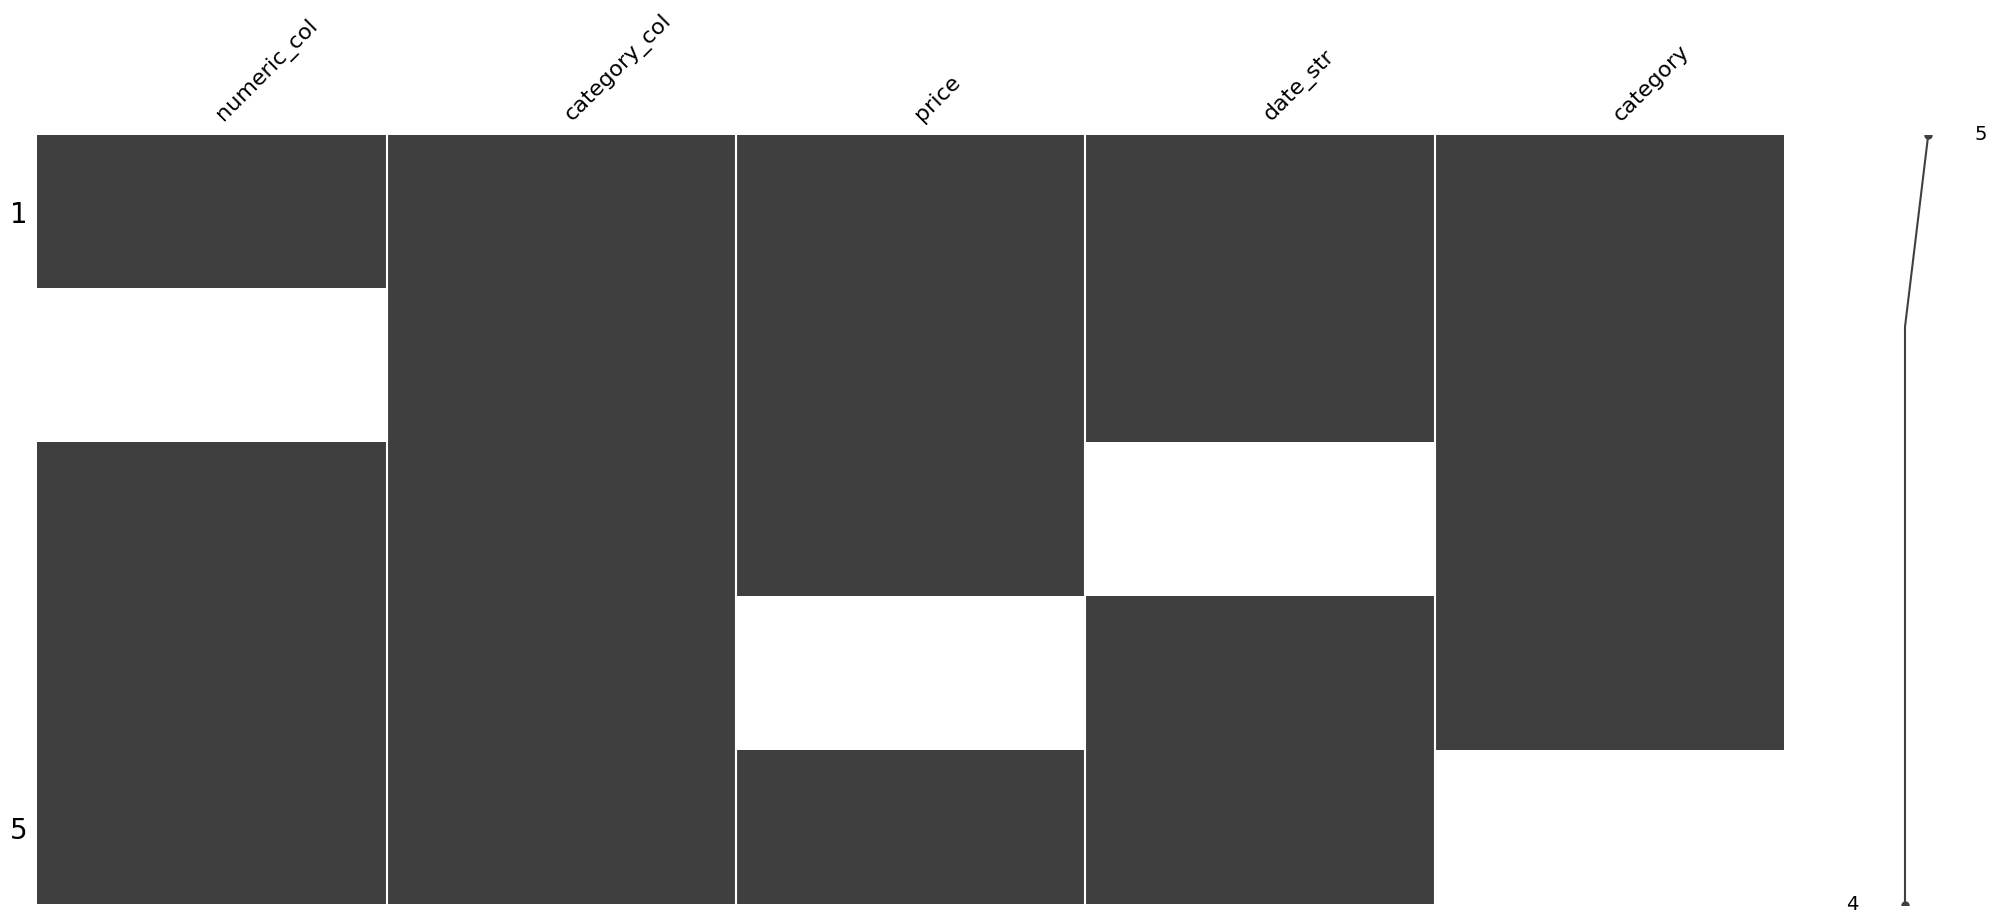

In [ ]:
# Basic info and missing counts
df.info()
df.isna().sum()

# Heatmap for missing data
sns.heatmap(df.isnull(), cbar=False)
plt.show()

# missingno visualization
msno.matrix(df)

## Simulate MCAR / MAR / MNAR Missingness

In [ ]:
# MCAR: random missing
df['MCAR_col'] = df['numeric_col'].mask(np.random.rand(len(df)) < 0.1)
# MAR: missing depends on another column
df['MAR_col'] = df['numeric_col'].mask(df['category_col']=='A')
# MNAR: missing depends on its own value
df['MNAR_col'] = df['numeric_col'].mask(df['numeric_col']>50)

## Handling Missing Values

In [ ]:
# Fill missing with median
df['numeric_col'] = df['numeric_col'].fillna(df['numeric_col'].median())

# Drop rows with missing MCAR
df.dropna(subset=['MCAR_col'], inplace=True)

# Alternative strategies
df_fill_mean = df.fillna(df.mean(numeric_only=True))
df_fill_median = df.fillna(df.median(numeric_only=True))
df_fill_ffill = df.fillna(method='ffill')

# Threshold-based row drop example
df_drop_thresh = df.dropna(thresh=int(0.5*df.shape[1]))

/tmp/ipython-input-1204882926.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_fill_ffill = df.fillna(method='ffill')


## Filtering Examples

In [ ]:
df_filtered = df[df['price'].str.replace('$','').astype(float) > 0]

## Type Corrections

In [ ]:
# Currency string to numeric
if 'price' in df.columns:
    df['price'] = df['price'].str.replace('$','').astype(float)

# Convert string to datetime
if 'date_str' in df.columns:
    df['date'] = pd.to_datetime(df['date_str'], errors='coerce')

# Standardize categorical column
if 'category' in df.columns:
    df['category'] = df['category'].str.lower().astype('category')

In [ ]:
# ---- Column Type Demo ----
# import pandas as pd
# import numpy as np

# Demo DataFrame for column types
df_types_demo = pd.DataFrame({
    'all_integers': [1, 2, 3, 4],
    'integers_with_nan': [1, 2, np.nan, 4],
    'text_column': ['a', 'b', 'c', 'd'],
    'mixed_column': [1, 'two', 3, 4]
})

print("Demo DataFrame:")
print(df_types_demo)

# Show column types
print("\nColumn types:")
print(df_types_demo.dtypes)

# Convert 'integers_with_nan' to nullable Int64
df_types_demo['integers_with_nan'] = df_types_demo['integers_with_nan'].astype('Int64')
print("\nAfter converting 'integers_with_nan' to Int64:")
print(df_types_demo.dtypes)

# Select numeric columns (generic)
numeric_cols = df_types_demo.select_dtypes(include='number').columns
print("\nNumeric columns (generic):", list(numeric_cols))

# Select object columns (generic)
object_cols = df_types_demo.select_dtypes(include='object').columns
print("Object columns (generic):", list(object_cols))


Demo DataFrame:
   all_integers  integers_with_nan text_column mixed_column
0             1                1.0           a            1
1             2                2.0           b          two
2             3                NaN           c            3
3             4                4.0           d            4

Column types:
all_integers           int64
integers_with_nan    float64
text_column           object
mixed_column          object
dtype: object

After converting 'integers_with_nan' to Int64:
all_integers          int64
integers_with_nan     Int64
text_column          object
mixed_column         object
dtype: object

Numeric columns (generic): ['all_integers', 'integers_with_nan']
Object columns (generic): ['text_column', 'mixed_column']


## Scaling and Normalization

In [ ]:
# MinMax scaling for numeric_col
scaler = MinMaxScaler()
df['numeric_scaled'] = scaler.fit_transform(df[['numeric_col']])

# StandardScaler
standardizer = StandardScaler()
df['numeric_standard'] = standardizer.fit_transform(df[['numeric_col']])

## Reusable Functions for Cleaning

In [ ]:
def fill_missing_median(df, columns=None):
    df_copy = df.copy()
    if columns is None:
        columns = df.select_dtypes(include=np.number).columns
    for col in columns:
        df_copy[col] = df_copy[col].fillna(df_copy[col].median())
    return df_copy

def drop_missing(df, columns=None, threshold=None):
    df_copy = df.copy()
    if columns is not None:
        return df_copy.dropna(subset=columns)
    if threshold is not None:
        return df_copy.dropna(thresh=int(threshold*df_copy.shape[1]))
    return df_copy.dropna()

def normalize_data(df, columns=None, method='minmax'):
    df_copy = df.copy()
    if columns is None:
        columns = df_copy.select_dtypes(include=np.number).columns
    if method=='minmax':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
    df_copy[columns] = scaler.fit_transform(df_copy[columns])
    return df_copy

def correct_column_types(df):
    df_copy = df.copy()
    if 'price' in df_copy.columns:
        df_copy['price'] = df_copy['price'].str.replace('$','').astype(float)
    if 'date_str' in df_copy.columns:
        df_copy['date'] = pd.to_datetime(df_copy['date_str'], errors='coerce')
    if 'category' in df_copy.columns:
        df_copy['category'] = df_copy['category'].str.lower().astype('category')
    return df_copy

## Validation & Save Cleaned Dataset

In [ ]:
# Apply reusable functions
df_cleaned = df.copy()
df_cleaned = fill_missing_median(df_cleaned)
df_cleaned = drop_missing(df_cleaned, threshold=0.5)
df_cleaned = normalize_data(df_cleaned)
df_cleaned = correct_column_types(df_cleaned)

# Inspect
df_cleaned.info()
df_cleaned.head()

# Save
df_cleaned.to_csv('data/processed/combined_cleaned_data.csv', index=False)

AttributeError: Can only use .str accessor with string values!

## Preprocessing Assumptions

When we clean and preprocess data, every choice encodes assumptions about the dataset. It's important to document these for reproducibility and stakeholder understanding.

### 1. Missing Data Handling
- Filling missing numeric values with median assumes the missingness is **MCAR or MAR** (not systematically biased).  
- Forward/backward fill assumes **temporal continuity** in time series data.  
- Dropping rows assumes the missing rows are **not critical** to analysis.  
- Imputation affects averages, distributions, and model training.

### 2. Understanding Missingness
- MCAR: safe to drop or fill, assumes randomness.  
- MAR: imputation using related features is valid.  
- MNAR: missing depends on unobserved values; may require domain knowledge.  
- Misidentifying missingness can bias results.

### 3. Filtering / Data Cleaning
- Removing negative or out-of-range values assumes they are **errors or invalid entries**.  
- Dropping columns or rows with excessive missingness assumes those data are **non-essential**.  
- Rare but valid events might be lost if thresholds are too strict.

### 4. Scaling / Normalization
- StandardScaler assumes features are roughly **normally distributed**.  
- MinMaxScaler assumes min and max values are **representative**, not extreme outliers.  
- Scaling changes interpretation of magnitudes; coefficients or distances may be affected.

### 5. Column Type Corrections
- Converting strings to numeric assumes there are **no hidden characters or formatting issues**.  
- Parsing dates assumes a **consistent date format**.  
- Categoricals assume a **finite, discrete set of values**.  
- Wrong types can break computations or modeling.

### 6. Reproducibility & Modularity
- Using modular functions assumes **future datasets follow similar structure and patterns**.  
- Documenting assumptions ensures that preprocessing is **transparent** and results are interpretable.

> **Tip:** Always communicate these assumptions to stakeholders, so they understand the limitations and decisions made during preprocessing.
